<a href="https://colab.research.google.com/github/aolszew/testRepoForDS4BME2020/blob/master/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names (Enter your names below)
Student 1 Name and JHED: Athena Olszewski, aolszew4


# Heart rate estimation, signal de-noising and mobile health
The goal of this lab is to study an algorithm for correctly retrieving the timing instants of an ECG (EKG) time series. We will implement a simplified variant of the [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings. Towards the end of the lab you will be asked to apply your algorithms to the problem of heart rate estimation using a mobile device.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Signal Generation -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $10$ equally spaced pulses over a time span of $10\ s$.  Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Plot the generated signal over time adding the appropriate labels for the axis.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Amplitude')

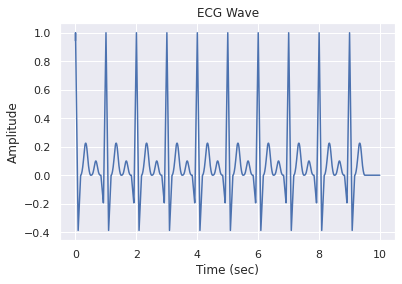

In [1]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Start your code below this line
# ============================================================================
# Plot the generated signal over time adding the appropriate labels for the axis.
f_s = 256
t = np.linspace(0, 1, f_s, endpoint = False)
imp = np.tile(signal.unit_impulse(256), 10 )
ecg_plain = np.convolve(ecg_wave(t), imp, 'same')
plt.figure()
plt.plot(np.linspace(0,10, ecg_plain.size), ecg_plain)
plt.title('ECG Wave')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')




* **Simulate Noise -** Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations.

Text(0, 0.5, 'Amplitude')

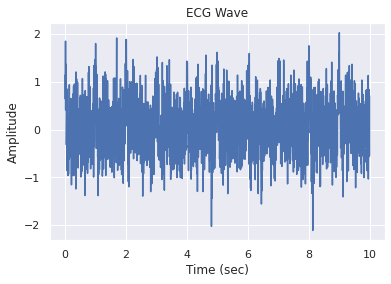

In [2]:
# ============================================================================
# Write your code here
# ============================================================================
sigma = 0.5
noise = np.random.normal(0, sigma, ecg_plain.size)
ecg_noisy = ecg_plain + noise
plt.figure()
plt.plot(np.linspace(0,10, ecg_noisy.size), ecg_noisy)
plt.title('ECG Wave')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')

* **Find Peaks -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate`.   We recommend that you normalize the signal to range $[0,1]$ using `noralize_range` before thresholding. Then plot the result. Next choose a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function with the `height` parameter set to the your chosen threshold.  Print the times of each peak in seconds.

[1. 2. 3. 4. 5. 6. 7. 8. 9.]


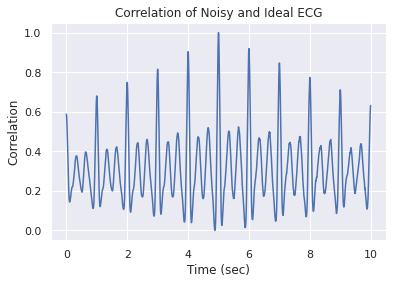

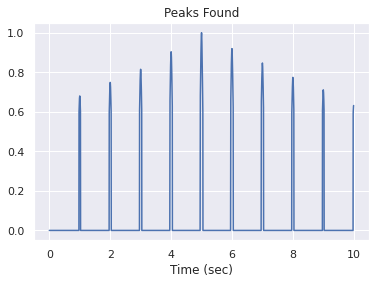

In [3]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:    
        return x
    
# ============================================================================
# Start your code below this line
# ============================================================================
correlation = np.correlate(ecg_noisy, ecg_plain, 'same')
correlation = normalize_range(correlation)
plt.figure()
plt.plot(np.linspace(0,10, correlation.size), correlation)
plt.title('Correlation of Noisy and Ideal ECG')
plt.xlabel('Time (sec)')
plt.ylabel('Correlation')
peaks = (correlation > 0.59) * correlation
plt.figure()
plt.plot(np.linspace(0,10, correlation.size), peaks)
plt.title('Peaks Found')
plt.xlabel('Time (sec)')
pulse, _ = signal.find_peaks(correlation, height = 0.59) 
pulse = np.array(pulse) / f_s
print(pulse)

* **RR Intervals -** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number intervals between peaks. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


Estimated bpm: 60.0


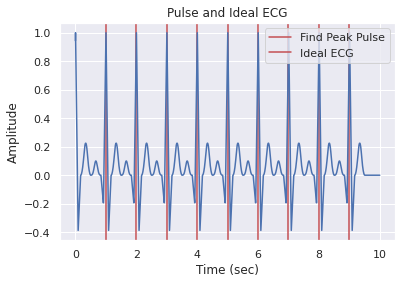

In [4]:
# ============================================================================
# Write your code here
# ============================================================================

plt.figure()
for i in pulse:
    plt.axvline(x=i, color='r')
plt.plot(np.linspace(0,10, correlation.size), ecg_plain)
plt.title('Pulse and Ideal ECG')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.legend(['Find Peak Pulse', 'Ideal ECG'])
RR = np.mean(np.diff(pulse))
bpm = 60 / RR 
print('Estimated bpm:', bpm)

### QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal where we don't know a priori the shape of the QRS-complex waeform. There are different
sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal
noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy 
individual where signal distortion comes solely from the acquisition process. The procedure that we
will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins
algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

* **Effect of noise** - Load the signal **ecg_mitnst.json**  You may have to change `path` to point to the correct loation where you downloaded **ecg_mitnst.json**. The loaded `data` dictionary will contain four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks.  Plot the voltage over time with the given peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

In [5]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================

try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = 'gdrive/My Drive/Colab Notebooks/ecg_mitnst.json' # Change path to location of data
except:
    # Executes if running locally (e.g. Anaconda)
    path = 'ecg_mitnst.json' # Change path to location of data

with open(path,'r') as infile: data = json.load(infile)

# print data to see dictionary fields
print(data.keys())



Mounted at gdrive/
dict_keys(['fs', 'time', 'tk', 'voltage'])


Text(0, 0.5, 'Voltage (mV)')

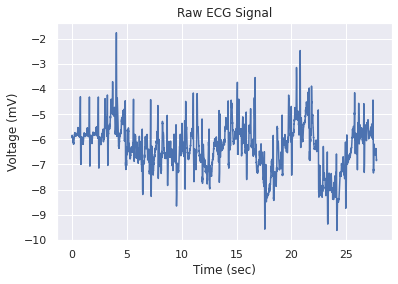

In [6]:
# ============================================================================
# Write your code here
# ============================================================================

plt.figure()
plt.plot(data["time"], data["voltage"])
plt.title('Raw ECG Signal')
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')

* **Pan-Tompkins Algorithm -** In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

  1. _Bandpass filtering:_ Follow the steps described in the instructions in order to perform a bandpass filtering operation as the concatenation of lowpass and highpass filtering operations.  For your convinence we have provided `boxFilter` and `triangleFilter` functions.
  
  2. _Differentiation:_ Use the discrete filter $d_n$ to approximate the derivative of the underlying signal:
  
    $$ d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big) $$
  
    The filter is intended to localize the steepest region in the QRS-complex.
  
  3. _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform.
  
  3. _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal.
  
  4. _Peak detection:_ Use a peak detector to estimate the locations of the peaks add them to the previous plot. Estimate the sequence of **RR** intervals and plot the corresponding heart beat rate over time.
 

Text(0, 0.5, 'bpm')

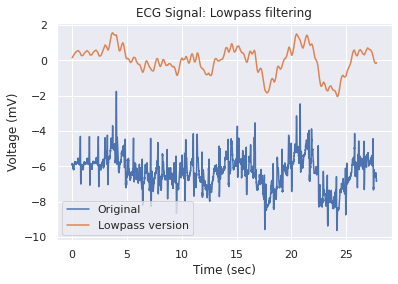

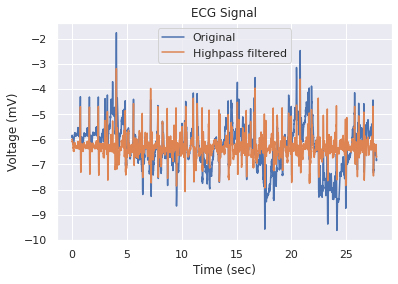

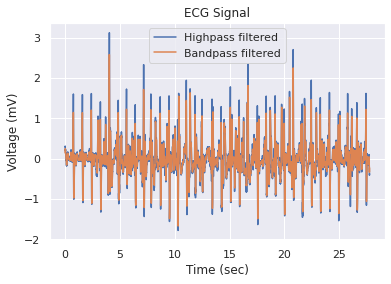

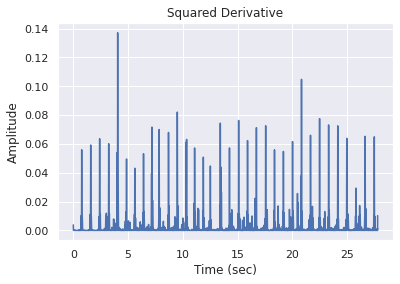

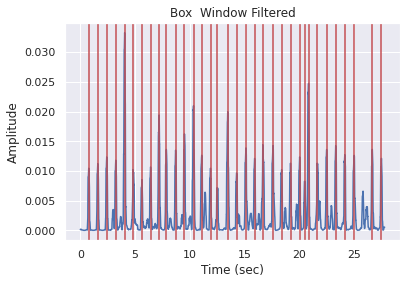

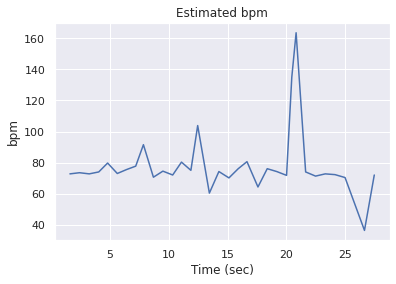

In [7]:
def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)


# ============================================================================
# Write your code here
# ============================================================================
#Step b

#Highpass filtering
L = 200
lowpass_filter = triangleFilter(L)
sig = data['voltage'] - np.mean(data['voltage'])
lowpass = np.convolve(sig, lowpass_filter, 'same')
highpass_filtered = data['voltage'] - lowpass
plt.figure()
plt.plot(data["time"], data["voltage"])
plt.plot(data["time"], lowpass)
plt.title('ECG Signal: Lowpass filtering')
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend(['Original', 'Lowpass version'])
plt.figure()
plt.plot(data["time"], data['voltage'])
plt.plot(data["time"], highpass_filtered)
plt.title('ECG Signal')
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend(['Original', 'Highpass filtered'])
#Lowpass filtering
highpass_filtered -= np.mean(highpass_filtered)
sig_band = np.convolve(boxFilter(10), highpass_filtered, 'same')
plt.figure()
plt.plot(data["time"], highpass_filtered)
plt.plot(data["time"], sig_band)
plt.title('ECG Signal')
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend(['Highpass filtered', 'Bandpass filtered'])
#Step c (don't need to plot) 
d = np.array([1, 2, 0, -2, -1]) / 8
sig_diff = np.convolve(d, sig_band, 'same')
#Step d (plot)
sig_diff = sig_diff ** 2
plt.figure()
plt.plot(data["time"], sig_diff)
plt.title('Squared Derivative')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
#Step e (plot)
sig_filtered = np.convolve(sig_diff, boxFilter(50), 'same')

#Step f (plot)
pulse, _ = signal.find_peaks(sig_filtered, height = 0.007, distance = 132)
time = data['time']
time_scale = time[2] - time[1]
sig_RR = np.diff(pulse)
pulse = pulse * time_scale
sig_RR = sig_RR * time_scale

plt.figure()
plt.plot(time, sig_filtered)
plt.title('Box  Window Filtered')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
for n in pulse:
    plt.axvline(x=n, color='r')
bpm = 60 / sig_RR 
plt.figure()
pulse = np.delete(pulse, 0)
plt.plot(pulse, bpm)
plt.title('Estimated bpm')
plt.xlabel('Time (sec)')
plt.ylabel('bpm')
